## <font color='red'>Game Of Thrones NLP analysis.</font>

### Introduction
In this particular notebook we are implementing a text analysis on the game of thrones corpus which was able as a open source.<br> The packages which we are using are<br>
1. nltk  #For preprocessing the text data.
2. numpy
3. pandas
4. gensim #High level library for creating the word2vec and libraries.
5. sklearn
6. matplotlib
7. seaborn

### The notebook follows below steps in creating the W2V for the GOT(Game of Thrones) data.<br>
<font color='blue'>step1:</font> Word2vec<br>
<font color='blue'>step2:</font>build_vocab()<br>
<font color='blue'>step3:</font>train()<br>

In [4]:
from __future__ import absolute_import, division, print_function
# __future__ is a missing compatability between the python 3.x and 2.x

In [18]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import multiprocessing
import logging
import random

In [6]:
import pprint
import re
import sklearn.manifold
import seaborn as sns
import gensim.models.word2vec as w2v
import codecs

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
# to remove the stop words and other gramatical words we download the punkt and stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
got_names=sorted(glob.glob("Got/*.txt"))
print(f'The available books are {got_names}')

The available books are ['Got\\got1.txt', 'Got\\got2.txt', 'Got\\got3.txt', 'Got\\got4.txt', 'Got\\got5.txt']


Now processing the data by combining all the available resources.

In [12]:
corpus_raw= u""# Creating a raw unicode.
for book_name in got_names:
    print(f'Reading {book_name}...')
    with codecs.open(book_name, "r", "utf-8") as book:
        corpus_raw+= book.read()# appending to the raw unicode.
    print(f"The total corpus is now {len(corpus_raw)} characters long")

Reading Got\got1.txt...
The total corpus is now 1770659 characters long
Reading Got\got2.txt...
The total corpus is now 4071041 characters long
Reading Got\got3.txt...
The total corpus is now 6391405 characters long
Reading Got\got4.txt...
The total corpus is now 8107945 characters long
Reading Got\got5.txt...
The total corpus is now 9719485 characters long


In [14]:
# Performing the tokenization
tokenizer= nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences=tokenizer.tokenize(corpus_raw)

In [15]:
## Now converting the sentences into a list of words that is we are performing the word tokenization.
def sentence_word_tokenize(raw_sent):
    clean=re.sub("[^a-zA-Z]"," ", raw_sent) #considering only words but not the punctuations.
    words=clean.split()
    return words

In [16]:
all_sentences=[]
for sentence_raw in raw_sentences:
    if len(sentence_raw)>0:
        temp_word=sentence_word_tokenize(sentence_raw)
        all_sentences.append(temp_word)

In [19]:
rand_number=random.randint(1,len(raw_sentences))
print(raw_sentences[rand_number])
print(all_sentences[rand_number])

“Lord Emmon does not need to breathe, so long as he can chew.
['Lord', 'Emmon', 'does', 'not', 'need', 'to', 'breathe', 'so', 'long', 'as', 'he', 'can', 'chew']


From the above we can see that we have created a lost of words for each sentence by ignoring the punctuations.<br>
Now checking the total number of words in the corpus.

In [21]:
tot_count=sum([len(each) for each in all_sentences])
print(f'The corpus has {tot_count} number of tokens')

The corpus has 1818103 number of tokens


<b> Now building the model and the glove(Global Vectors for Word Representation)</b><br>
Declaring the hyper parameters for creating the model.

In [24]:
num_features=300
min_word_count=3
num_workers=multiprocessing.cpu_count()
context_size=7
downsampling= 1e-3
seed =1 

In [27]:
#sg=1 defines to use skip-gram
#workers is the number of threads to run in parallel
#window = The maximum distance between the current and predicted word within a sentence.
#sample = The threshold for configuring which higher-frequency words are randomly downsampled.
got2vec= w2v.Word2Vec(sg=1,
                     seed=seed,
                     workers=num_workers,
                     size=num_features,
                     min_count=min_word_count,
                     window=context_size,
                     sample=downsampling)

In [28]:
# Building the vacab with the all_sentences
got2vec.build_vocab(all_sentences)

In [29]:
print("Word2Vec vocabulary length:", len(got2vec.wv.vocab))

Word2Vec vocabulary length: 17277


In [60]:
#train model on sentneces
got2vec.train(all_sentences,total_examples=got2vec.corpus_count,epochs=40,report_delay=1)

(56177917, 72724120)

##### Now saving the model to use TSNE( t-Distributed Stochastic Neighbor Embedding) which is a non linear dimentionality reduction algorithm.

In [61]:
#save model
if not os.path.exists("trained_model"):
    os.makedirs("trained_model")

In [62]:
got2vec.save(os.path.join("trained_model", "got2vec.w2v"))

C:\Users\Chandra\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [63]:
# Now loading the model.
got2vec = w2v.Word2Vec.load(os.path.join("trained_model", "got2vec.w2v"))

C:\Users\Chandra\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [64]:
# As the model is high dimentional, reducing it to 2 dimensinal.
# For more on TNSE check in the references list provided.
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [65]:
#Creating a single matrix
all_word_vectors_matrix = got2vec.wv.vectors

In [66]:
## Training the tsne model.
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [67]:
# Now creating a dataframe of the words witht he coordinates so that we can visualize in 2D.
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[got2vec.wv.vocab[word].index])
            for word in got2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head()

,word,x,y
0,This,10.007949,-5.004674
1,edition,-15.196252,-29.486864
2,the,-3.782735,1.964086
3,complete,16.918018,-24.751562
4,of,-3.646099,1.704041


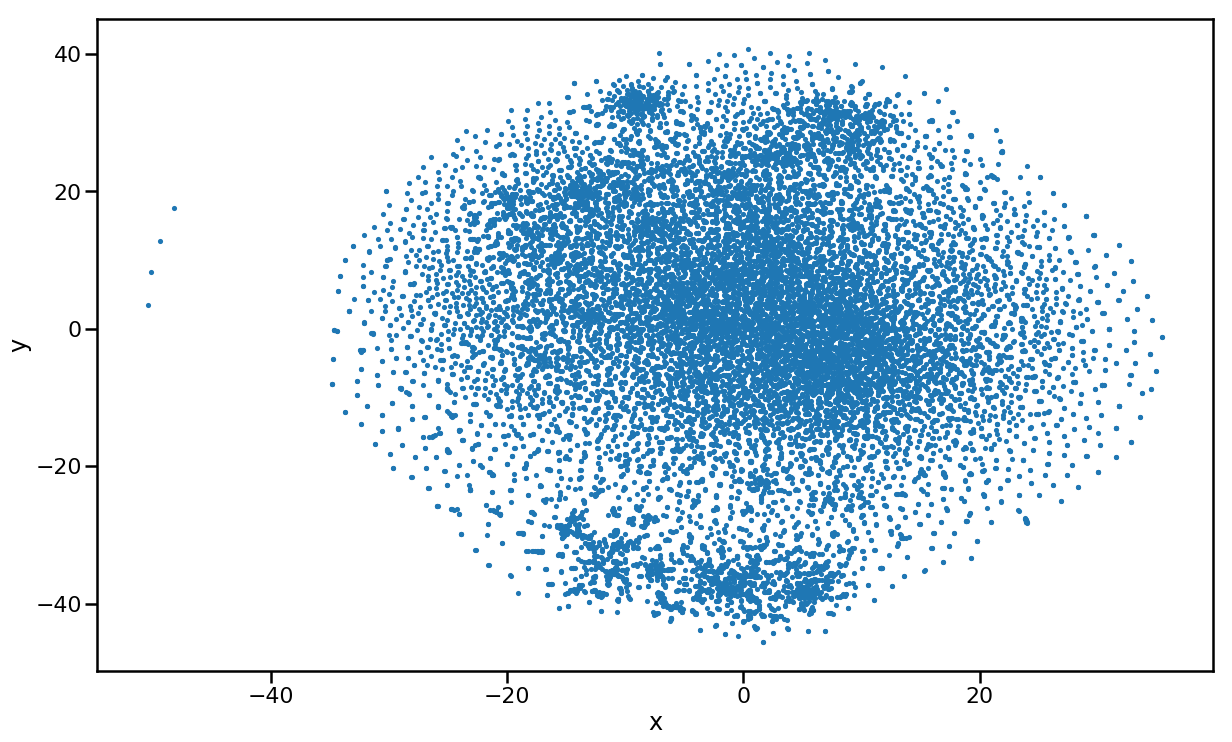

In [68]:
#plot
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [69]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

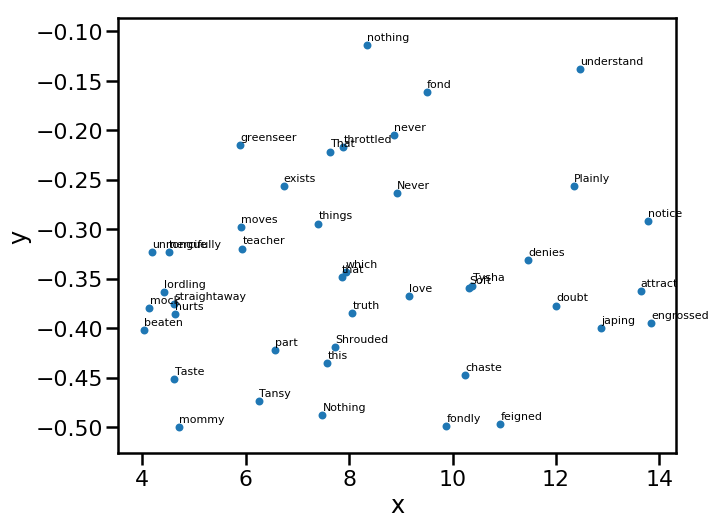

In [70]:
plot_region(x_bounds=(4.0, 15), y_bounds=(-0.5, -0.1))

In [71]:
got2vec.most_similar("Eddard")

C:\Users\Chandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Stark', 0.6267850399017334),
 ('MOLLEN', 0.4173576831817627),
 ('Winterfell', 0.41697415709495544),
 ('divulge', 0.4123377501964569),
 ('HALLIS', 0.4120681881904602),
 ('executed', 0.4095630347728729),
 ('Ned', 0.4011881351470947),
 ('Lord', 0.3965049684047699),
 ('declare', 0.38282859325408936),
 ('Edrick', 0.375145822763443)]

In [72]:
got2vec.most_similar("Arya")

C:\Users\Chandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Underfoot', 0.48180925846099854),
 ('she', 0.45224639773368835),
 ('Horseface', 0.4392489790916443),
 ('Gendry', 0.4181327223777771),
 ('Sansa', 0.41782882809638977),
 ('Lumpyhead', 0.4177662134170532),
 ('Lommy', 0.39709222316741943),
 ('guiltily', 0.39055341482162476),
 ('Hot', 0.37911760807037354),
 ('Weasel', 0.37831807136535645)]

In [79]:
got2vec.most_similar("Jon",topn=20)

C:\Users\Chandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Snow', 0.6570173501968384),
 ('Ygritte', 0.412655770778656),
 ('Qhorin', 0.408436119556427),
 ('guiltily', 0.3814550042152405),
 ('Arson', 0.3768726587295532),
 ('he', 0.3744887709617615),
 ('MAR', 0.36721765995025635),
 ('TUN', 0.3644900321960449),
 ('Ghost', 0.3602372407913208),
 ('Bran', 0.3588077425956726),
 ('DOH', 0.35517048835754395),
 ('Sam', 0.3546481430530548),
 ('MAG', 0.3484266698360443),
 ('Dalbridge', 0.34429407119750977),
 ('cackling', 0.3424132466316223),
 ('Satin', 0.3418167233467102),
 ('Orell', 0.3364652991294861),
 ('truthfully', 0.3326970338821411),
 ('speechless', 0.3326537013053894),
 ('Styr', 0.3323550820350647)]

From the above testing we can see that how different charaters are related to the words in the givven corpus, which has been implemented witht the help of W2V.

### <font color='blue'> References: </font>
1. More insight on the t-SNE algoritham from O'Reilly. https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm <br>
2. Getting to know about the Word2VEC and GLOVE(Global Vectors for Word Representation). https://nlp.stanford.edu/projects/glove/<br>
3. scikit learn documentation on the t-SNE documentation. https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html<br>
4. Matplotlib documentation for plotting beatiful graphs. https://matplotlib.org/gallery/index.html <br>
5. Gensim W2V tutorial and documentation https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial <br>